In [6]:
import torch
import pickle

import numpy as np
from utils.vmf_batch import vMF
from models import PoolingClassifier
from utils.training_utils import create_model

## plotting ###

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
from openTSNE import initialization, TSNEEmbedding
from openTSNE.affinity import PerplexityBasedNN
from sklearn.decomposition import PCA

pca = PCA()
SEED = 17

In [3]:
 # save the data for other notebooks
def save_r_T(model_path, save_path, fractions):
    
    for k, frac in enumerate(fractions):
    
        for run in range(1,4):
            state_dict = torch.load(model_path%(frac, run))
            model.load_state_dict(state_dict['model_state_dict'])
            classifier.load_state_dict(state_dict['classifier_state_dict'])
            model.eval()
            with torch.no_grad():



                bs, n_walks, walk_length, input_dim = src_data_train.shape
                src = src_data_train.view(-1,walk_length,input_dim).transpose(0,1).to(device)
                # src = [walk length , bs * n_walks, input_dim]
                trg = trg_data_train.view(-1,walk_length,input_dim).transpose(0,1).to(device)
                seq_len = seq_len_train.view(-1).to(device)
                _ = model(src, seq_len, trg, 0)


                Z_grouped_train = model.Z.reshape(bs,1,n_walks,-1)
                Z_grouped_train = classifier.pooling_layer(Z_grouped_train).squeeze().cpu() 


                bs, n_walks, walk_length, input_dim = src_data_val.shape
                src = src_data_val.view(-1,walk_length,input_dim).transpose(0,1).to(device)
                # src = [walk length , bs * n_walks, input_dim]
                trg = trg_data_val.view(-1,walk_length,input_dim).transpose(0,1).to(device)
                seq_len = seq_len_val.view(-1).to(device)
                _ = model(src, seq_len, trg, 0)

                Z_grouped_val = model.Z.reshape(bs,1,n_walks,-1)
                Z_grouped_val = classifier.pooling_layer(Z_grouped_val).squeeze().cpu() 


                bs, n_walks, walk_length, input_dim = src_data_test.shape
                src = src_data_test.view(-1,walk_length,input_dim).transpose(0,1).to(device)
                # src = [walk length , bs * n_walks, input_dim]
                trg = trg_data_test.view(-1,walk_length,input_dim).transpose(0,1).to(device)
                seq_len = seq_len_test.view(-1).to(device)
                _ = model(src, seq_len, trg, 0)

                Z_grouped_test = model.Z.reshape(bs,1,n_walks,-1)
                Z_grouped_test = classifier.pooling_layer(Z_grouped_test).squeeze().cpu() 

            with open(save_path + 'neuron_latent_representation_frac_%.1f_run%i_train'%(frac, run), 'wb') as f:
                np.save(f, Z_grouped_train)
            with open(save_path + 'neuron_latent_representation_frac_%.1f_run%i_val'%(frac,run), 'wb') as f:
                np.save(f, Z_grouped_val)
            with open(save_path + 'neuron_latent_representation_frac_%.1f_run%i_test'%(frac,run), 'wb') as f:
                np.save(f, Z_grouped_test)
torch.cuda.empty_cache()

## Toy neurons

In [4]:
SEED = 17
pop = '3_populations'
with open('./data/toy_data/%s/iterator/train_iterator.pkl'%pop, 'rb') as f:
    train_iterator = pickle.load(f)

with open('./data/toy_data/%s/iterator/test_iterator.pkl'%pop, 'rb') as f:
    test_iterator = pickle.load(f)

In [8]:

# get data
np.random.seed(SEED)
torch.random.manual_seed(SEED)
src_data_test, trg_data_test, seq_len_test, indices_test, labels_test = list(test_iterator)[0]

_, n_walks, walk_length, f = src_data_test.shape

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = dict(input_dim =3, embed_dim=32, hidden_dim=32, latent_dim=32, num_layers = 2, kappa=500, dropout=.1)
model = create_model(config, device)

NUM_CLASSES = len(np.unique(labels_test))
classifier = PoolingClassifier(config['latent_dim'], NUM_CLASSES, n_walks,config['dropout'], 'max')

KLD: 45.709938049316406


In [9]:
with open('./models/3_populations/losses_emb32_hid32_lat32_dp0.1_k500_max_frac1.0_2.npy', 'rb') as f:
    l = np.load(f)
l[:,3].min() # --> best class loss is 2nd model

14.0878916015625

In [6]:
# save the data for other notebooks
for k, frac in enumerate([1.,.9,.5,.1,.0]):
    
    for run in range(1,4):
        state_dict = torch.load('./models/classification_analysis/k500/vae_frac_%.2f_run%i.pt'%(frac, run))
        model.load_state_dict(state_dict['model_state_dict'])
        classifier.load_state_dict(state_dict['classifier_state_dict'])

        with torch.no_grad():
            
            np.random.seed(SEED)
            torch.random.manual_seed(SEED)
            Z_grouped_train = torch.Tensor([])
            train_labels = torch.Tensor([]).to(torch.long)
            for src_data, trg_data, seq_len, indices, labels in train_iterator:
                bs, n_walks, walk_length, input_dim = src_data.shape
                src = src_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
                # src = [walk length , bs * n_walks, input_dim]
                trg = trg_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
                seq_len = seq_len.view(-1).to(device)
                _ = model(src, seq_len, trg, 0)


                Z_grouped_train_ = model.Z.reshape(bs,1,n_walks,LATENT_DIM)
                Z_grouped_train_ = classifier.pooling_layer(Z_grouped_train_).squeeze().cpu() 
                Z_grouped_train = torch.cat((Z_grouped_train, Z_grouped_train_))
                
                train_labels = torch.cat((train_labels, labels))
                      
            bs, n_walks, walk_length, input_dim = src_data_test.shape
            src = src_data_test.view(-1,walk_length,input_dim).transpose(0,1).to(device)
            # src = [walk length , bs * n_walks, input_dim]
            trg = trg_data_test.view(-1,walk_length,input_dim).transpose(0,1).to(device)
            seq_len = seq_len_test.view(-1).to(device)
            _ = model(src, seq_len, trg, 0)

            Z_grouped_test = model.Z.reshape(bs,1,n_walks,LATENT_DIM)
            Z_grouped_test = classifier.pooling_layer(Z_grouped_test).squeeze().cpu() 
        with open('./data/toy_data/3_populations/latent/k500/neuron_latent_representation_frac_%.1f_run%i_train'%(frac, run), 'wb') as f:
            np.save(f, Z_grouped_train)
        with open('./data/toy_data/3_populations/latent/k500/neuron_latent_representation_frac_%.1f_run%i_test'%(frac,run), 'wb') as f:
            np.save(f, Z_grouped_test)
torch.cuda.empty_cache()

In [10]:
from openTSNE import TSNE
tsne = TSNE(
    perplexity=30,
    initialization="pca",
    metric="cosine",
    random_state=17,
    )



CPU times: user 11.5 s, sys: 194 ms, total: 11.7 s
Wall time: 11.5 s
CPU times: user 11.2 s, sys: 169 ms, total: 11.4 s
Wall time: 11.1 s
CPU times: user 11.4 s, sys: 185 ms, total: 11.6 s
Wall time: 11.3 s


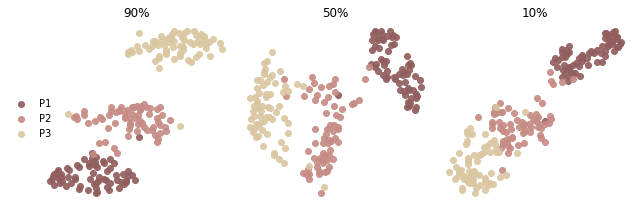

In [11]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
colors = sns.color_palette('pink', n_colors=4)
for k, (frac, run) in enumerate([(.9,3),(.5,1),(.1,3)]):
    
    with open('./data/toy_data/3_populations/latent/k500/neuron_latent_representation_frac_%.1f_run%i_test'%(frac,run), 'rb') as f:
        Z_grouped = np.load(f)
    # fit t-SNE 
    %time tsne_fit_grp = tsne.fit(np.array(Z_grouped))

    axes[k].scatter(tsne_fit_grp[labels_test == 0, 0], tsne_fit_grp[labels_test == 0, 1], 
                alpha=.9, label='P1', c=[colors[0]])
    axes[k].scatter(tsne_fit_grp[labels_test == 1, 0], 
                tsne_fit_grp[labels_test == 1, 1],
                alpha=.9, label='P2', c=[colors[1]])
    axes[k].scatter(tsne_fit_grp[labels_test == 2, 0], 
                tsne_fit_grp[labels_test == 2, 1],
                alpha=.9, label='P3', c=[colors[2]])
    axes[k].axis('off')
    axes[k].set_title(str(int(frac*100))+'%')

sns.despine()
axes[0].legend(frameon=False, bbox_to_anchor=(.1,.3))
plt.tight_layout()
# plt.savefig("./pics/ICML/v3/Fig5/tsne_toy_neurons_embedding.svg", format='svg')

### What if I max pool over the walk matrix itself

Max pool over the 256 walks and then stack them

In [6]:
max_pool = torch.nn.MaxPool3d(kernel_size=(256,1,1))
SEED = 17

In [7]:
# get the train data
np.random.seed(SEED)
torch.random.manual_seed(SEED)
trg_data_train = torch.Tensor([])
train_labels = torch.Tensor([]).to(torch.long)
for src_data, trg_data, seq_len, indices, labels in train_iterator:
    trg_data_train = torch.cat((trg_data_train, trg_data))
    train_labels = torch.cat((train_labels, labels))

In [10]:
# save the max pooled over original walk data

with open('./data/toy_data/3_populations/max-pooled/max_pooled_train.npy', 'wb') as f:
    bs = trg_data_train.shape[0]
    max_pooled_trg_train = max_pool(trg_data_train).squeeze().reshape(bs, -1)
    np.save(f, max_pooled_trg_train)
with open('./data/toy_data/3_populations/max-pooled/train_labels.npy', 'wb') as f:
    np.save(f,train_labels)
    
    
with open('./data/toy_data/3_populations/max-pooled/max_pooled_test.npy', 'wb') as f:
    bs = trg_data_test.shape[0]
    max_pooled_trg = max_pool(trg_data_test).squeeze().reshape(bs, -1)
    np.save(f, max_pooled_trg)
with open('./data/toy_data/3_populations/max-pooled/test_labels.npy', 'wb') as f:
    np.save(f,labels_test)

In [11]:
from openTSNE import TSNE
tsne = TSNE(
    perplexity=30,
    initialization="pca",
    metric="euclidean",
    random_state=17,
    )
%time tsne_fit_max_pooled = tsne.fit(np.array(max_pooled_trg))

CPU times: user 15.3 s, sys: 306 ms, total: 15.6 s
Wall time: 15.7 s


Text(0.5, 1.0, 't-SNE on max-pooled original walks')

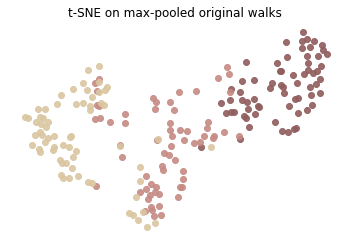

In [12]:
colors = sns.color_palette('pink', n_colors=4)
plt.scatter(tsne_fit_max_pooled[labels_test == 0, 0], 
            tsne_fit_max_pooled[labels_test == 0, 1], 
            alpha=.9, label='P1', c=[colors[0]])
plt.scatter(tsne_fit_max_pooled[labels_test == 1, 0], 
            tsne_fit_max_pooled[labels_test == 1, 1],
            alpha=.9, label='P2', c=[colors[1]])
plt.scatter(tsne_fit_max_pooled[labels_test == 2, 0], 
            tsne_fit_max_pooled[labels_test == 2, 1],
            alpha=.9, label='P3', c=[colors[2]])
plt.axis('off')
plt.title('t-SNE on max-pooled original walks')
# plt.savefig('./pics/ICML/resubmission/Fig4/tsne_max_pooled_original_walks.svg')

# real neurons: EXC

## EXC m type labels

In [5]:
## check which run has the smalles classification loss

import os
PATH = './models/M1_exc/m_label/'

root, _, files = list(os.walk(PATH))[0]
npy_files = [f for f in files if f.split('.')[-1] == 'npy']
npy_files.sort()

cut_off = -1

# Combine the runs and take the average
loss_dict= {}
for npy_file in npy_files:
    
    with open(PATH+npy_file, 'rb') as f:
        losses = np.load(f)
        
        key = npy_file.split('_')[2][-3:]
        if key not in loss_dict.keys():
            loss_dict[key] = losses[:cut_off]
        else:
            loss_dict[key] = np.hstack((loss_dict[key], losses[:cut_off]))

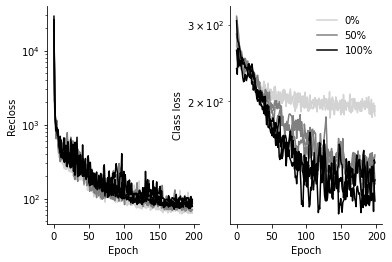

In [8]:
plt.subplot(121)
plt.plot(loss_dict['0.0'][150:,2::4]- loss_dict['0.0'][150:,3::4], c='lightgrey')
plt.plot(loss_dict['0.5'][150:,2::4]- loss_dict['0.5'][150:,3::4], c='grey')
plt.plot(loss_dict['1.0'][150:,2::4]- loss_dict['1.0'][150:,3::4], c='k')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Recloss')

plt.subplot(122)
plt.plot(loss_dict['0.0'][150:,3::4], c='lightgrey', label='0%')
plt.plot(loss_dict['0.5'][150:,3::4], c='grey', label='50%')
plt.plot(loss_dict['1.0'][150:,3::4], c='k', label='100%')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Class loss')
handles, legend_labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::3], legend_labels[::3], frameon=False)
sns.despine()

In [18]:
key = '0.0'
ix_1, ix_2, ix_3 = loss_dict[key][:,2::4].argmin(axis=0)
print('MSE: [ %.2f, %.2f , %.2f ]'%(loss_dict[key][ix_1,2]-loss_dict[key][ix_1,3], 
      loss_dict[key][ix_2,6] -loss_dict[key][ix_2,7], 
      loss_dict[key][ix_3,10]-  loss_dict[key][ix_3,11]))

print('Class:[ %.2f, %.2f , %.2f ]'%(loss_dict[key][ix_1,3], loss_dict[key][ix_2,7],loss_dict[key][ix_3,11]))

MSE: [ 69.41, 63.89 , 65.97 ]
Class:[ 189.48, 193.72 , 187.72 ]



    Finetuned unsupervised: 
            [69.4131036931818 63.89058948863638 65.97009943181817]     MSE
            [189.47990056818182 193.72093394886363 187.71525213068182] Class

    Finetuned supervised: 
            [98.59223188920454 76.37474254261365 76.96265980113637] MSE
            [110.70347123579545 113.71194069602272 114.64096235795455] Class

In [22]:
with open('./data/M1_exc_data/iterator/m_labels/train_iterator.pkl', 'rb') as f:
    train_iterator = pickle.load(f)

with open('./data/M1_exc_data/iterator/m_labels/val_iterator.pkl', 'rb') as f:
    val_iterator = pickle.load(f)
    
with open('./data/M1_exc_data/iterator/m_labels/test_iterator.pkl', 'rb') as f:
    test_iterator = pickle.load(f)


In [23]:
SEED = 17
# get data
np.random.seed(SEED)
torch.manual_seed(SEED)
src_data_train = torch.Tensor()
trg_data_train = torch.Tensor() 
seq_len_train = torch.Tensor()
indices_train = torch.Tensor().to(torch.long)
labels_train = torch.Tensor().to(torch.long)

for sd, td, sl, ti, lt in list(train_iterator):
    src_data_train = torch.cat((src_data_train,sd),dim=0)
    trg_data_train = torch.cat((trg_data_train,td),dim=0)
    seq_len_train = torch.cat((seq_len_train,sl),dim=0)
    indices_train = torch.cat((indices_train,ti),dim=0)
    labels_train = torch.cat((labels_train,lt),dim=0)

src_data_val, trg_data_val, seq_len_val, indices_val, labels_val = list(val_iterator)[0]
src_data_test, trg_data_test, seq_len_test, indices_test, labels_test = list(test_iterator)[0]

_ , n_walks, walk_length, f = src_data_test.shape

In [19]:
# with open('./data/M1_exc_data/latent/m_labels/labels/test_labels.npy', 'wb') as f:
#     np.save(f, labels_test)

# with open('./data/M1_exc_data/latent/m_labels/labels/val_labels.npy', 'wb') as f:
#     np.save(f, labels_val)
    
# with open('./data/M1_exc_data/latent/m_labels/labels/train_labels.npy', 'wb') as f:
#     np.save(f, labels_train)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = dict(input_dim =3, embed_dim=32, hidden_dim=32, latent_dim=32, num_layers = 2, kappa=500, dropout=.1)
model = create_model(config, device)

NUM_CLASSES = 3

classifier = PoolingClassifier(config['latent_dim'], NUM_CLASSES, n_walks,config['dropout'], 'max')

KLD: 45.709938049316406


In [35]:
fractions = [1.,0.] #[1., .9, .5, .1, 0.]

model_path = './models/M1_exc/m_label/finetuned_vae_k500_frac%.1f_best_run%i.pt'
save_path = './data/M1_exc_data/latent/m_labels/'

# caution this line of code takes long!
save_r_T(model_path, save_path, fractions)

torch.cuda.empty_cache()

CPU times: user 177 µs, sys: 12 µs, total: 189 µs
Wall time: 24.3 µs
CPU times: user 128 ms, sys: 3.77 ms, total: 132 ms
Wall time: 12 ms
CPU times: user 8.45 s, sys: 118 ms, total: 8.57 s
Wall time: 7.7 s
CPU times: user 215 µs, sys: 14 µs, total: 229 µs
Wall time: 30 µs
CPU times: user 330 ms, sys: 897 µs, total: 331 ms
Wall time: 26 ms
CPU times: user 8.41 s, sys: 140 ms, total: 8.55 s
Wall time: 7.72 s


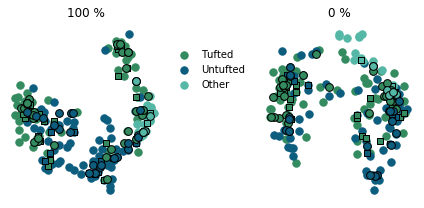

In [144]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
colors =['#338b5f', 
        '#0d5d7f',
        '#55b7a6']
s=60

for k, (frac, run) in enumerate([(1.,1),(0.,1)]):
    
    with open('./data/M1_exc_data/latent/m_labels/neuron_latent_representation_frac_%.1f_run%i_train'%(frac, run), 'rb') as f:
        Z_grouped_train = np.load(f)
    with open('./data/M1_exc_data/latent/m_labels/neuron_latent_representation_frac_%.1f_run%i_val'%(frac,run), 'rb') as f:
        Z_grouped_val = np.load(f)
    with open('./data/M1_exc_data/latent/m_labels/neuron_latent_representation_frac_%.1f_run%i_test'%(frac,run), 'rb') as f:
        Z_grouped_test = np.load(f)
    
    Z_grouped_train_pca = pca.fit_transform(np.array(Z_grouped_train))
    %time
    affinities_train = PerplexityBasedNN(
        Z_grouped_train_pca,
        perplexity=30,
        metric="cosine",
        n_jobs=2,
        random_state=17,
    )

    %time init_train = initialization.pca(Z_grouped_train_pca, random_state=17)

    embedding_train = TSNEEmbedding(
        init_train,
        affinities_train,
        negative_gradient_method="fft",
        n_jobs=2
    )

    %time embedding_train = embedding_train.optimize(n_iter=500, momentum=0.8)

    embedding_val = embedding_train.prepare_partial(
        pca.transform(np.array(Z_grouped_val)),
        initialization="median",
        k=5,
        perplexity=5,
    )
    
    embedding_test = embedding_train.prepare_partial(
        pca.transform(np.array(Z_grouped_test)),
        initialization="median",
        k=5,
        perplexity=5,
    )
    
    axes[k].scatter(embedding_train[labels_train == 0, 0], embedding_train[labels_train == 0, 1], 
            alpha=1, c=[colors[0]], s=s-5,label='Tufted')
    axes[k].scatter(embedding_train[labels_train == 1, 0], 
            embedding_train[labels_train == 1, 1],
            alpha=1, c=[colors[1]],s=s-5,label='Untufted')
    axes[k].scatter(embedding_train[labels_train == 2, 0], 
            embedding_train[labels_train == 2, 1],
            alpha=1, c=[colors[2]], s=s-5,label='Other')

    axes[k].scatter(embedding_val[labels_val == 0, 0], embedding_val[labels_val == 0, 1], 
            alpha=1,edgecolors='k', s=s-15,c=[colors[0]], marker = 's')
    axes[k].scatter(embedding_val[labels_val == 1, 0], embedding_val[labels_val == 1, 1], 
            alpha=1, edgecolors='k',s=s-15,c=[colors[1]], marker = 's')
    axes[k].scatter(embedding_val[labels_val == 2, 0], 
            embedding_val[labels_val == 2, 1], 
            alpha=1,edgecolors='k', s=s-15,c=[colors[2]], marker = 's')
    axes[k].axis('off')
    
    axes[k].scatter(embedding_test[labels_test == 0, 0], embedding_test[labels_test == 0, 1], 
            alpha=1, edgecolors='k', s=s,c=[colors[0]])
    axes[k].scatter(embedding_test[labels_test == 1, 0], embedding_test[labels_test == 1, 1], 
            alpha=1, edgecolors='k', s=s,c=[colors[1]])
    axes[k].scatter(embedding_test[labels_test == 2, 0], 
            embedding_test[labels_test == 2, 1], 
            alpha=1, edgecolors='k', s=s,c=[colors[2]])
    axes[k].axis('off')

    axes[k].set_title('%i'%int(frac*100)+' %')

sns.despine()
axes[0].legend(frameon=False, bbox_to_anchor=(1.,.9))
plt.tight_layout()
plt.savefig("./pics/ICML/camera-ready/Fig6/EXC_rT.svg", format='svg')

## Max pool over original walks

In [26]:
# save the max pooled over original walk data

max_pool = torch.nn.MaxPool3d(kernel_size=(256,1,1))

with open('./data/M1_exc_data/max-pooled/max_pooled_train.npy', 'wb') as f:
    bs = trg_data_train.shape[0]
    max_pooled_trg_train = max_pool(trg_data_train).squeeze().reshape(bs, -1)
    np.save(f, max_pooled_trg_train)
with open('./data/M1_exc_data/max-pooled/train_labels.npy', 'wb') as f:
    np.save(f,labels_train)
    
    
with open('./data/M1_exc_data/max-pooled/max_pooled_test.npy', 'wb') as f:
    bs = trg_data_test.shape[0]
    max_pooled_trg = max_pool(trg_data_test).squeeze().reshape(bs, -1)
    np.save(f, max_pooled_trg)
with open('./data/M1_exc_data/max-pooled/test_labels.npy', 'wb') as f:
    np.save(f,labels_test)

CPU times: user 12.9 s, sys: 280 ms, total: 13.2 s
Wall time: 12.7 s


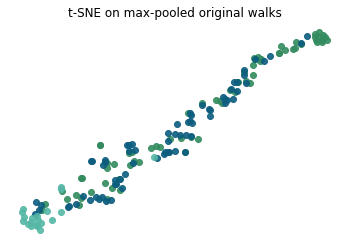

In [27]:
# max pool over the 3d walks directly


bs = trg_data_train.shape[0]
max_pooled_trg = max_pool(trg_data_train).squeeze().reshape(bs, -1)


from openTSNE import TSNE
tsne = TSNE(
    perplexity=20,
    initialization="pca",
    metric="euclidean",
    random_state=17,
    )
%time tsne_fit_max_pooled = tsne.fit(np.array(max_pooled_trg))

colors =['#338b5f', 
        '#0d5d7f',
        '#55b7a6']
plt.scatter(tsne_fit_max_pooled[labels_train == 0, 0], 
            tsne_fit_max_pooled[labels_train == 0, 1], 
            alpha=.9, label='P1', c=[colors[0]])
plt.scatter(tsne_fit_max_pooled[labels_train == 1, 0], 
            tsne_fit_max_pooled[labels_train == 1, 1],
            alpha=.9, label='P2', c=[colors[1]])
plt.scatter(tsne_fit_max_pooled[labels_train == 2, 0], 
            tsne_fit_max_pooled[labels_train == 2, 1],
            alpha=.9, label='P3', c=[colors[2]])
plt.axis('off')
plt.title('t-SNE on max-pooled original walks')
# plt.savefig('./pics/ICML/camera-ready/Suppl/m1_exc_max_pooled.svg')

# On inhibitory neurons - finetuned

In [65]:
## check which run has the smalles classification loss

import os
part = 'axon'
PATH = './models/M1_inh/finetuned/%s/'%part

root, _, files = list(os.walk(PATH))[0]
npy_files = [f for f in files if f.split('.')[-1] == 'npy' and f.split("_")[1] == 'losses']
npy_files.sort()

cut_off = -1

# Combine the runs and take the average
loss_dict= {}
for npy_file in npy_files:
    
    with open(PATH+npy_file, 'rb') as f:
        losses = np.load(f)
        
        key = npy_file.split('_')[2][-3:]
        if key not in loss_dict.keys():
            loss_dict[key] = losses[:cut_off]
        else:
            loss_dict[key] = np.hstack((loss_dict[key], losses[:cut_off]))

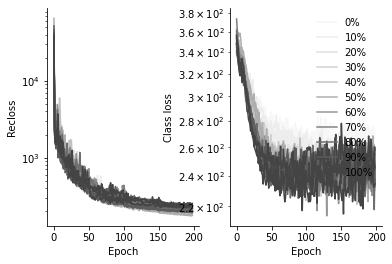

In [66]:
plt.subplot(121)
cs = sns.color_palette('Greys', n_colors=13)
for k, key in enumerate(loss_dict.keys()):
    plt.plot(loss_dict[key][150:,2::4]- loss_dict[key][150:,3::4], c=cs[k])

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Recloss')

plt.subplot(122)
for k, key in enumerate(loss_dict.keys()):
    plt.plot(loss_dict[key][150:,3::4], c=cs[k],  label='%i'%int(float(key)*100) + '%')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Class loss')
handles, legend_labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::3], legend_labels[::3], frameon=False)
sns.despine()

In [67]:
key = '0.5'
ix_1, ix_2, ix_3 = loss_dict[key][:,2::4].argmin(axis=0)
print('MSE: [ %.2f, %.2f , %.2f ]'%(loss_dict[key][ix_1,2]-loss_dict[key][ix_1,3], 
      loss_dict[key][ix_2,6] -loss_dict[key][ix_2,7], 
      loss_dict[key][ix_3,10]-  loss_dict[key][ix_3,11]))

print('Class: [ %.2f, %.2f , %.2f ]'%(loss_dict[key][ix_1,3], loss_dict[key][ix_2,7],loss_dict[key][ix_3,11]))

MSE: [ 219.27, 179.70 , 184.20 ]
Class: [ 225.75, 229.59 , 232.68 ]


In [35]:
temp = [ 236.53, 221.12 , 249.84  ]
np.mean(temp).round(2)

235.83

Finetuned: 
    
    fully supervised full: [206.91727570564515 198.1431136592742 205.82064327116936] MSE
                          [223.29287424395162 225.30547505040323 209.89753969254033] Classification
    
    unsupervised full: [155.76792464717744 161.69417842741933 166.4510143649194] MSE
                       [272.08222026209677 264.4908959173387 267.333259828629] Class
                       
                       
    fully supervised axon: [236.5260049143145 221.12156628024192 249.83629977318552] MSE
                          [230.27660345262098 248.79422883064515 218.43423954133064] Classification
    
    unsupervised axon: [204.69362714213707 197.21024445564512 209.9272933467742] MSE
                       [256.33856791834677 262.4445564516129 252.1173135080645] Class
                       

In [36]:
with open('./data/M1_inh_data/iterator/%s/train_iterator_32.pkl'%part, 'rb') as f:
    train_iterator = pickle.load(f)

with open('./data/M1_inh_data/iterator/%s/val_iterator_32.pkl'%part, 'rb') as f:
    val_iterator = pickle.load(f)
    
with open('./data/M1_inh_data/iterator/%s/test_iterator_32.pkl'%part, 'rb') as f:
    test_iterator = pickle.load(f)


In [37]:
SEED = 17
# get data
np.random.seed(SEED)
torch.manual_seed(SEED)
src_data_train = torch.Tensor()
trg_data_train = torch.Tensor() 
seq_len_train = torch.Tensor()
indices_train = torch.Tensor().to(torch.long)
labels_train = torch.Tensor().to(torch.long)

for sd, td, sl, ti, lt in list(train_iterator):
    src_data_train = torch.cat((src_data_train,sd),dim=0)
    trg_data_train = torch.cat((trg_data_train,td),dim=0)
    seq_len_train = torch.cat((seq_len_train,sl),dim=0)
    indices_train = torch.cat((indices_train,ti),dim=0)
    labels_train = torch.cat((labels_train,lt),dim=0)

src_data_val, trg_data_val, seq_len_val, indices_val, labels_val = list(val_iterator)[0]
src_data_test, trg_data_test, seq_len_test, indices_test, labels_test = list(test_iterator)[0]

_ , n_walks, walk_length, f = src_data_test.shape

In [59]:
# with open('./data/M1_inh_data/latent/labels/test_labels.npy', 'wb') as f:
#     np.save(f, labels_test)

# with open('./data/M1_inh_data/latent/labels/val_labels.npy', 'wb') as f:
#     np.save(f, labels_val)
    
# with open('./data/M1_inh_data/latent/labels/train_labels.npy', 'wb') as f:
#     np.save(f, labels_train)

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = dict(input_dim =3, embed_dim=32, hidden_dim=32, latent_dim=32, num_layers = 2, kappa=500, dropout=.1)

model = create_model(config, device)
NUM_CLASSES = 4
classifier = PoolingClassifier(config['latent_dim'],  NUM_CLASSES, n_walks,config['dropout'], 'max')

KLD: 45.709938049316406


In [39]:
fractions = [1.,0.9,.5,.1, 0.]

model_path = './models/M1_inh/finetuned/' + part +'/finetuned_vae_frac%.1f_best_run%i.pt'
save_path = './data/M1_inh_data/latent/%s/finetuned/'%part
# save_r_T(model_path, save_path, fractions)



In [38]:
from openTSNE import initialization, TSNEEmbedding
from openTSNE.affinity import PerplexityBasedNN
from sklearn.decomposition import PCA

pca = PCA()

CPU times: user 148 µs, sys: 8 µs, total: 156 µs
Wall time: 19.8 µs
CPU times: user 423 ms, sys: 1.67 ms, total: 424 ms
Wall time: 32.6 ms
CPU times: user 8.56 s, sys: 127 ms, total: 8.69 s
Wall time: 7.77 s
CPU times: user 217 µs, sys: 12 µs, total: 229 µs
Wall time: 29.3 µs
CPU times: user 225 ms, sys: 4.32 ms, total: 229 ms
Wall time: 18 ms
CPU times: user 8.51 s, sys: 131 ms, total: 8.65 s
Wall time: 7.75 s


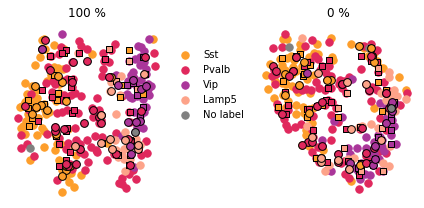

In [66]:
fig, axes = plt.subplots(1,2,figsize=(6,3))
colors = ['#fd9e2b', '#e0285d', '#aa369a', '#fda389']
s=60

# TODO get best classification runs
for k, (frac, run) in enumerate([(1.,3),(0.,3)]):
    
    with open(save_path+ 'neuron_latent_representation_frac_%.1f_run%i_train'%(frac, run), 'rb') as f:
        Z_grouped_train = np.load(f)
    with open(save_path+ 'neuron_latent_representation_frac_%.1f_run%i_val'%(frac,run), 'rb') as f:
        Z_grouped_val = np.load(f)
    with open(save_path+'neuron_latent_representation_frac_%.1f_run%i_test'%(frac,run), 'rb') as f:
        Z_grouped_test = np.load(f)
    
    Z_grouped_train_pca = pca.fit_transform(np.array(Z_grouped_train))
    %time
    affinities_train = PerplexityBasedNN(
        Z_grouped_train_pca,
        perplexity=30,
        metric="cosine",
        n_jobs=2,
        random_state=17,
    )

    %time init_train = initialization.pca(Z_grouped_train_pca, random_state=17)

    embedding_train = TSNEEmbedding(
        init_train,
        affinities_train,
        negative_gradient_method="fft",
        n_jobs=2
    )

    %time embedding_train = embedding_train.optimize(n_iter=500, momentum=0.8)

    embedding_val = embedding_train.prepare_partial(
        pca.transform(np.array(Z_grouped_val)),
        initialization="median",
        k=5,
        perplexity=5,
    )
    
    embedding_test = embedding_train.prepare_partial(
        pca.transform(np.array(Z_grouped_test)),
        initialization="median",
        k=5,
        perplexity=5,
    )
    
    axes[k].scatter(embedding_train[labels_train == 0, 0], embedding_train[labels_train == 0, 1], 
            alpha=1, c=[colors[0]], s=s-5,label='Sst')
    axes[k].scatter(embedding_train[labels_train == 1, 0], 
            embedding_train[labels_train == 1, 1],
            alpha=1, c=[colors[1]],s=s-5,label='Pvalb')
    axes[k].scatter(embedding_train[labels_train == 2, 0], 
            embedding_train[labels_train == 2, 1],
            alpha=1, c=[colors[2]], s=s-5,label='Vip')
    axes[k].scatter(embedding_train[labels_train == 3, 0], 
            embedding_train[labels_train == 3, 1],
            alpha=1, c=[colors[3]], s=s-5,label='Lamp5')
    axes[k].scatter(embedding_train[labels_train == -100, 0], 
            embedding_train[labels_train == -100, 1],
            alpha=1, c='grey', s=s-5,label='No label')

    axes[k].scatter(embedding_val[labels_val == 0, 0], embedding_val[labels_val == 0, 1], 
            alpha=1,edgecolors='k', s=s-15,c=[colors[0]], marker = 's')
    axes[k].scatter(embedding_val[labels_val == 1, 0], embedding_val[labels_val == 1, 1], 
            alpha=1, edgecolors='k',s=s-15,c=[colors[1]], marker = 's')
    axes[k].scatter(embedding_val[labels_val == 2, 0], 
            embedding_val[labels_val == 2, 1], 
            alpha=1,edgecolors='k', s=s-15,c=[colors[2]], marker = 's')
    axes[k].scatter(embedding_val[labels_val == 3, 0], 
            embedding_val[labels_val == 3, 1], 
            alpha=1,edgecolors='k', s=s-15,c=[colors[3]], marker = 's')
    axes[k].scatter(embedding_val[labels_val == -100, 0], 
            embedding_val[labels_val == -100, 1], 
            alpha=1,edgecolors='k', s=s-15,c='grey', marker = 's')  
    axes[k].axis('off')
    
    axes[k].scatter(embedding_test[labels_test == 0, 0], embedding_test[labels_test == 0, 1], 
            alpha=1, edgecolors='k', s=s,c=[colors[0]])
    axes[k].scatter(embedding_test[labels_test == 1, 0], embedding_test[labels_test == 1, 1], 
            alpha=1, edgecolors='k', s=s,c=[colors[1]])
    axes[k].scatter(embedding_test[labels_test == 2, 0], 
            embedding_test[labels_test == 2, 1], 
            alpha=1, edgecolors='k', s=s,c=[colors[2]])
    axes[k].scatter(embedding_test[labels_test == 3, 0], 
            embedding_test[labels_test == 3, 1], 
            alpha=1, edgecolors='k', s=s,c=[colors[3]])
    axes[k].scatter(embedding_test[labels_test == -100, 0], 
            embedding_test[labels_test == -100, 1], 
            alpha=1, edgecolors='k', s=s,c='grey')
    axes[k].axis('off')
    axes[k].set_title('%i'%int(frac*100)+' %')

sns.despine()
axes[0].legend(frameon=False, bbox_to_anchor=(1.,.9))
plt.tight_layout()
plt.savefig('./pics/ICML/camera-ready/Fig6/INH_rT.svg')

## Max pool over orignal walks directly

In [35]:
# save the max pooled over original walk data

max_pool = torch.nn.MaxPool3d(kernel_size=(256,1,1))

with open('./data/M1_inh_data/max-pooled/max_pooled_train_%s.npy'%part, 'wb') as f:
    bs = trg_data_train.shape[0]
    max_pooled_trg_train = max_pool(trg_data_train).squeeze().reshape(bs, -1)
    np.save(f, max_pooled_trg_train)
with open('./data/M1_inh_data/max-pooled/train_labels.npy', 'wb') as f:
    np.save(f,train_labels)
    
    
with open('./data/M1_inh_data/max-pooled/max_pooled_test_%s.npy'%part, 'wb') as f:
    bs = trg_data_test.shape[0]
    max_pooled_trg = max_pool(trg_data_test).squeeze().reshape(bs, -1)
    np.save(f, max_pooled_trg)
with open('./data/M1_inh_data/max-pooled/test_labels.npy', 'wb') as f:
    np.save(f,labels_test)

CPU times: user 13.8 s, sys: 255 ms, total: 14.1 s
Wall time: 13 s


Text(0.5, 1.0, 't-SNE on max-pooled original walks')

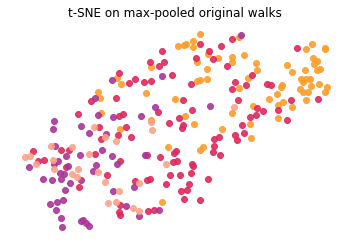

In [36]:
# max pool over the 3d walks directly

max_pool = torch.nn.MaxPool3d(kernel_size=(256,1,1))
bs = trg_data_train.shape[0]
max_pooled_trg = max_pool(trg_data_train).squeeze().reshape(bs, -1)


from openTSNE import TSNE
tsne = TSNE(
    perplexity=20,
    initialization="pca",
    metric="euclidean",
    random_state=17,
    )
%time tsne_fit_max_pooled = tsne.fit(np.array(max_pooled_trg))

colors = ['#fd9e2b', '#e0285d', '#aa369a', '#fda389']

for l in np.unique(labels_train)[1:]:
    
    plt.scatter(tsne_fit_max_pooled[labels_train == l, 0], 
                tsne_fit_max_pooled[labels_train == l, 1], 
                alpha=.9, c=[colors[l]])

plt.axis('off')
plt.title('t-SNE on max-pooled original walks')

# On inhibitory neurons - from scratch

In [45]:
## check which run has the smalles classification loss

import os
part ='axon'
PATH = './models/M1_inh/scratch/%s/'%part

root, _, files = list(os.walk(PATH))[0]
npy_files = [f for f in files if f.split('.')[-1] == 'npy' and f.split("_")[0] == 'losses']
npy_files.sort()

cut_off = -1


# Combine the runs and take the average
loss_dict= {}
for npy_file in npy_files:
    
    with open(PATH+npy_file, 'rb') as f:
        losses = np.load(f)
        
        key = npy_file.split('_')[1][-3:]
        if key not in loss_dict.keys():
            loss_dict[key] = losses[:cut_off]
        else:
            loss_dict[key] = np.hstack((loss_dict[key], losses[:cut_off]))

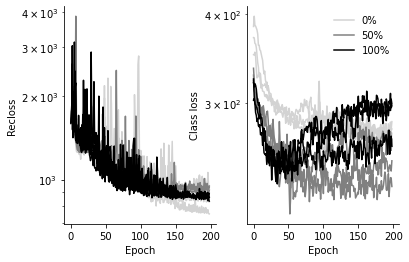

In [48]:
plt.subplot(121)
plt.plot(loss_dict['0.0'][:,2::4]- loss_dict['0.0'][:,3::4], c='lightgrey')
plt.plot(loss_dict['0.5'][:,2::4]- loss_dict['0.5'][:,3::4], c='grey')
plt.plot(loss_dict['1.0'][:,2::4]- loss_dict['1.0'][:,3::4], c='k')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Recloss')

plt.subplot(122)
plt.plot(loss_dict['0.0'][:,3::4], c='lightgrey', label='0%')
plt.plot(loss_dict['0.5'][:,3::4], c='grey', label='50%')
plt.plot(loss_dict['1.0'][:,3::4], c='k', label='100%')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Class loss')
handles, legend_labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::3], legend_labels[::3], frameon=False)
sns.despine()

In [49]:
key = '0.0'
ix_1, ix_2, ix_3 = loss_dict[key][:,2::4].argmin(axis=0)
print('MSE: ', loss_dict[key][ix_1,2]-loss_dict[key][ix_1,3], 
       loss_dict[key][ix_2,6] -loss_dict[key][ix_2,7],
      loss_dict[key][ix_3,10]-  loss_dict[key][ix_3,11])

print('Class: ', loss_dict[key][ix_1,3], loss_dict[key][ix_2,7],loss_dict[key][ix_3,11])

MSE:  894.8395602318549 756.3145476310484 830.1317099294354
Class:  269.74461315524195 267.7557648689516 269.0627205141129


From scratch:
      
      supervised axon:
        [859.1242439516129 838.6320564516129 835.9240486391129] MSE
        [266.56073588709677 264.76902721774195 297.7306892641129] Class
        
      unsupervised axon:
        [894.8395602318549 756.3145476310484 830.1317099294354] MSE
        [269.74461315524195 267.7557648689516 269.0627205141129] Class

In [187]:
with open('./data/M1_inh_data/iterator/%s/train_iterator_32.pkl'%part, 'rb') as f:
    train_iterator = pickle.load(f)

with open('./data/M1_inh_data/iterator/%s/val_iterator_32.pkl'%part, 'rb') as f:
    val_iterator = pickle.load(f)
    
with open('./data/M1_inh_data/iterator/%s/test_iterator_32.pkl'%part, 'rb') as f:
    test_iterator = pickle.load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = dict(input_dim =3, embed_dim=32, hidden_dim=32, latent_dim=32, num_layers = 2, kappa=500, dropout=.1)

model = create_model(config, device)
NUM_CLASSES = 4
classifier = PoolingClassifier(config['latent_dim'], NUM_CLASSES, n_walks,config['dropout'], 'max')


SEED = 17
# get data
np.random.seed(SEED)
torch.manual_seed(SEED)
src_data_train = torch.Tensor()
trg_data_train = torch.Tensor() 
seq_len_train = torch.Tensor()
indices_train = torch.Tensor().to(torch.long)
labels_train = torch.Tensor().to(torch.long)

for sd, td, sl, ti, lt in list(train_iterator):
    src_data_train = torch.cat((src_data_train,sd),dim=0)
    trg_data_train = torch.cat((trg_data_train,td),dim=0)
    seq_len_train = torch.cat((seq_len_train,sl),dim=0)
    indices_train = torch.cat((indices_train,ti),dim=0)
    labels_train = torch.cat((labels_train,lt),dim=0)

src_data_val, trg_data_val, seq_len_val, indices_val, labels_val = list(val_iterator)[0]
src_data_test, trg_data_test, seq_len_test, indices_test, labels_test = list(test_iterator)[0]

_ , n_walks, walk_length, f = src_data_test.shape

KLD: 45.709938049316406


In [188]:
fractions = [1.,.5, 0.]

model_path = './models/M1_inh/finetuned/' + part +'/finetuned_scaled_vae_frac%.1f_best_run%i.pt'
save_path = './data/M1_inh_data/latent/%s/scratch/scaled_'%part

save_r_T(model_path, save_path, fractions)

CPU times: user 24 µs, sys: 3 µs, total: 27 µs
Wall time: 19.3 µs
CPU times: user 319 ms, sys: 1.59 ms, total: 321 ms
Wall time: 48.9 ms
CPU times: user 10.3 s, sys: 152 ms, total: 10.4 s
Wall time: 9.7 s
CPU times: user 13 µs, sys: 2 µs, total: 15 µs
Wall time: 13.8 µs
CPU times: user 192 ms, sys: 208 µs, total: 192 ms
Wall time: 29.7 ms
CPU times: user 10.4 s, sys: 136 ms, total: 10.6 s
Wall time: 9.76 s
CPU times: user 68 µs, sys: 9 µs, total: 77 µs
Wall time: 17.4 µs
CPU times: user 215 ms, sys: 283 µs, total: 216 ms
Wall time: 29.1 ms
CPU times: user 10.3 s, sys: 141 ms, total: 10.4 s
Wall time: 9.62 s


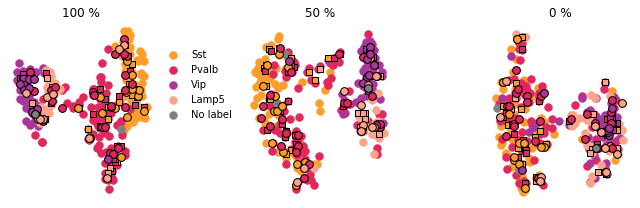

In [194]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
colors = ['#fd9e2b', '#e0285d', '#aa369a', '#fda389']
s=60

# TODO get best classification runs
for k, (frac, run) in enumerate([(1.,3),(.5,1),(0.,1)]):
    
    with open(save_path+ 'neuron_latent_representation_frac_%.1f_run%i_train'%(frac, run), 'rb') as f:
        Z_grouped_train = np.load(f)
    with open(save_path+ 'neuron_latent_representation_frac_%.1f_run%i_val'%(frac,run), 'rb') as f:
        Z_grouped_val = np.load(f)
    with open(save_path+'neuron_latent_representation_frac_%.1f_run%i_test'%(frac,run), 'rb') as f:
        Z_grouped_test = np.load(f)
    
    Z_grouped_train_pca = pca.fit_transform(np.array(Z_grouped_train))
    %time
    affinities_train = PerplexityBasedNN(
        Z_grouped_train_pca,
        perplexity=30,
        metric="cosine",
        n_jobs=2,
        random_state=17,
    )

    %time init_train = initialization.pca(Z_grouped_train_pca, random_state=17)

    embedding_train = TSNEEmbedding(
        init_train,
        affinities_train,
        negative_gradient_method="fft",
        n_jobs=2
    )

    %time embedding_train = embedding_train.optimize(n_iter=500, momentum=0.8)

    embedding_val = embedding_train.prepare_partial(
        pca.transform(np.array(Z_grouped_val)),
        initialization="median",
        k=5,
        perplexity=5,
    )
    
    embedding_test = embedding_train.prepare_partial(
        pca.transform(np.array(Z_grouped_test)),
        initialization="median",
        k=5,
        perplexity=5,
    )
    
    axes[k].scatter(embedding_train[labels_train == 0, 0], embedding_train[labels_train == 0, 1], 
            alpha=1, c=[colors[0]], s=s-5,label='Sst')
    axes[k].scatter(embedding_train[labels_train == 1, 0], 
            embedding_train[labels_train == 1, 1],
            alpha=1, c=[colors[1]],s=s-5,label='Pvalb')
    axes[k].scatter(embedding_train[labels_train == 2, 0], 
            embedding_train[labels_train == 2, 1],
            alpha=1, c=[colors[2]], s=s-5,label='Vip')
    axes[k].scatter(embedding_train[labels_train == 3, 0], 
            embedding_train[labels_train == 3, 1],
            alpha=1, c=[colors[3]], s=s-5,label='Lamp5')
    axes[k].scatter(embedding_train[labels_train == -100, 0], 
            embedding_train[labels_train == -100, 1],
            alpha=1, c='grey', s=s-5,label='No label')

    axes[k].scatter(embedding_val[labels_val == 0, 0], embedding_val[labels_val == 0, 1], 
            alpha=1,edgecolors='k', s=s-15,c=[colors[0]], marker = 's')
    axes[k].scatter(embedding_val[labels_val == 1, 0], embedding_val[labels_val == 1, 1], 
            alpha=1, edgecolors='k',s=s-15,c=[colors[1]], marker = 's')
    axes[k].scatter(embedding_val[labels_val == 2, 0], 
            embedding_val[labels_val == 2, 1], 
            alpha=1,edgecolors='k', s=s-15,c=[colors[2]], marker = 's')
    axes[k].scatter(embedding_val[labels_val == 3, 0], 
            embedding_val[labels_val == 3, 1], 
            alpha=1,edgecolors='k', s=s-15,c=[colors[3]], marker = 's')
    axes[k].scatter(embedding_val[labels_val == -100, 0], 
            embedding_val[labels_val == -100, 1], 
            alpha=1,edgecolors='k', s=s-15,c='grey', marker = 's')  
    axes[k].axis('off')
    
    axes[k].scatter(embedding_test[labels_test == 0, 0], embedding_test[labels_test == 0, 1], 
            alpha=1, edgecolors='k', s=s,c=[colors[0]])
    axes[k].scatter(embedding_test[labels_test == 1, 0], embedding_test[labels_test == 1, 1], 
            alpha=1, edgecolors='k', s=s,c=[colors[1]])
    axes[k].scatter(embedding_test[labels_test == 2, 0], 
            embedding_test[labels_test == 2, 1], 
            alpha=1, edgecolors='k', s=s,c=[colors[2]])
    axes[k].scatter(embedding_test[labels_test == 3, 0], 
            embedding_test[labels_test == 3, 1], 
            alpha=1, edgecolors='k', s=s,c=[colors[3]])
    axes[k].scatter(embedding_test[labels_test == -100, 0], 
            embedding_test[labels_test == -100, 1], 
            alpha=1, edgecolors='k', s=s,c='grey')
    axes[k].axis('off')
    axes[k].set_title('%i'%int(frac*100)+' %')

sns.despine()
axes[0].legend(frameon=False, bbox_to_anchor=(1.,.9))
plt.tight_layout()

plt.savefig("./pics/ICML/camera-ready/Suppl/M1_INH_rT_scratch.svg")

# On Farrow data - fine tuned

In [71]:
## check which run has the smalles classification loss

import os
part ='soma_centered'
PATH = './models/Farrow/finetuned/%s/'%part

root, _, files = list(os.walk(PATH))[0]
npy_files = [f for f in files if f.split('.')[-1] == 'npy' and f.split("_")[1] == 'losses' ]
npy_files.sort()

cut_off = 303


# Combine the runs and take the average
loss_dict= {}
for npy_file in npy_files:
    
    with open(PATH+npy_file, 'rb') as f:
        losses = np.load(f)
        
        key = npy_file.split('_')[2][-3:]
        if key not in loss_dict.keys():
            loss_dict[key] = losses[:cut_off]
        else:
            loss_dict[key] = np.hstack((loss_dict[key], losses[:cut_off]))

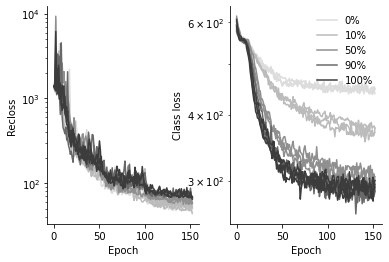

In [73]:
plt.subplot(121)
cs = sns.color_palette('Greys', n_colors=20)[4::3]
for k, key in enumerate(loss_dict.keys()):
    plt.plot(loss_dict[key][150:,2::4]- loss_dict[key][150:,3::4], c=cs[k])

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Recloss')

plt.subplot(122)
for k, key in enumerate(loss_dict.keys()):
    plt.plot(loss_dict[key][150:,3::4], c=cs[k],  label='%i'%int(float(key)*100) + '%')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Class loss')
handles, legend_labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::3], legend_labels[::3], frameon=False)
sns.despine()

In [75]:
key = '0.0'
ix_1, ix_2, ix_3 = loss_dict[key][:,2::4].argmin(axis=0)
print('MSE: [ %.2f, %.2f, %.2f]' %(loss_dict[key][ix_1,2]-loss_dict[key][ix_1,3], 
      loss_dict[key][ix_2,6] -loss_dict[key][ix_2,7], 
      loss_dict[key][ix_3,10]-  loss_dict[key][ix_3,11]))

print('Class: [ %.2f, %.2f, %.2f]' %(loss_dict[key][ix_1,3], loss_dict[key][ix_2,7],loss_dict[key][ix_3,11]))

MSE: [ 43.45, 53.44, 49.82]
Class: [ 438.62, 440.94, 438.97]


Finetuned:

    unsupervised 
                [52.06368371212125 52.41591698232327 56.7261679292929] MSE
                [454.62551294191917 455.5296717171717 457.35894097222223] Class 
                
    supervised
                [79.79206123737373 76.10878314393943 80.41084674873736] MSE
                [281.33952809343435 294.59023832070704 290.1558751578283] Class

In [69]:
with open('./data/Farrow_data/iterator/%s/train_iterator.pkl'%part, 'rb') as f:
    train_iterator = pickle.load(f)

with open('./data/Farrow_data/iterator/%s/val_iterator.pkl'%part, 'rb') as f:
    val_iterator = pickle.load(f)
    
with open('./data/Farrow_data/iterator/%s/test_iterator.pkl'%part, 'rb') as f:
    test_iterator = pickle.load(f)

SEED = 17
# get data
np.random.seed(SEED)
torch.manual_seed(SEED)
src_data_train = torch.Tensor()
trg_data_train = torch.Tensor() 
seq_len_train = torch.Tensor()
indices_train = torch.Tensor().to(torch.long)
labels_train = torch.Tensor().to(torch.long)

for sd, td, sl, ti, lt in list(train_iterator):
    src_data_train = torch.cat((src_data_train,sd),dim=0)
    trg_data_train = torch.cat((trg_data_train,td),dim=0)
    seq_len_train = torch.cat((seq_len_train,sl),dim=0)
    indices_train = torch.cat((indices_train,ti),dim=0)
    labels_train = torch.cat((labels_train,lt),dim=0)

src_data_val, trg_data_val, seq_len_val, indices_val, labels_val = list(val_iterator)[0]
src_data_test, trg_data_test, seq_len_test, indices_test, labels_test = list(test_iterator)[0]

_ , n_walks, walk_length, f = src_data_test.shape


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = dict(input_dim =3, embed_dim=32, hidden_dim=32, latent_dim=32, num_layers = 2, kappa=500, dropout=.1)

model = create_model(config, device)
NUM_CLASSES = 14
classifier = PoolingClassifier(config['latent_dim'], NUM_CLASSES, n_walks,config['dropout'], 'max')

KLD: 45.709938049316406


In [70]:
np.unique(labels_train, return_counts=True)

(array([-100,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
          10,   11,   12,   13]),
 array([34, 76, 21,  8, 11, 31, 62, 15, 21, 13, 29, 12, 14, 31, 22]))

In [24]:
# with open('./data/Farrow_data/latent/soma_centered/labels/test_labels.npy', 'wb') as f:
#     np.save(f, labels_test)

# with open('./data/Farrow_data/latent/soma_centered/labels/val_labels.npy', 'wb') as f:
#     np.save(f, labels_val)
    
# with open('./data/Farrow_data/latent/soma_centered/labels/train_labels.npy', 'wb') as f:
#     np.save(f, labels_train)

In [145]:
fractions = [1.,.9, .5, 0.]

model_path = './models/Farrow/finetuned/' + part +'/finetuned_vae_frac%.1f_best_run%i.pt'
save_path = './data/Farrow_data/latent/%s/finetuned/'%part
# save_r_T(model_path, save_path, fractions)

In [26]:
from openTSNE import TSNE
tsne = TSNE(
    perplexity=30,
    initialization="pca",
    metric="cosine",
    random_state=17,
    )


CPU times: user 196 µs, sys: 12 µs, total: 208 µs
Wall time: 29.3 µs
CPU times: user 408 ms, sys: 1.82 ms, total: 410 ms
Wall time: 31.5 ms
CPU times: user 8.51 s, sys: 118 ms, total: 8.62 s
Wall time: 7.72 s
CPU times: user 211 µs, sys: 13 µs, total: 224 µs
Wall time: 29.1 µs
CPU times: user 432 ms, sys: 2.3 ms, total: 434 ms
Wall time: 32.8 ms
CPU times: user 8.56 s, sys: 103 ms, total: 8.67 s
Wall time: 7.75 s


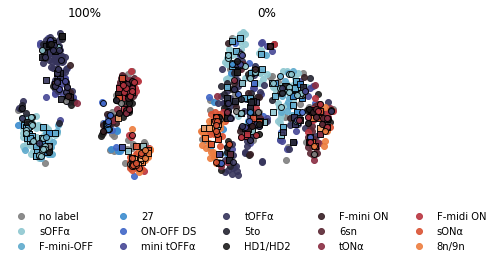

In [149]:
label_dict = {-100:'no label', 13: '8n/9n', 12: 'sONα', 11: 'F-midi ON', 
              10: 'tONα', 9:'6sn', 8:'F-mini ON', 7:'HD1/HD2', 
              6:'5to', 5:'tOFFα', 4: 'mini tOFFα', 3: 'ON-OFF DS',
             2: '27', 1:'F-mini-OFF', 0: 'sOFFα'}
fig, axes = plt.subplots(1,2,figsize=(6,3))
colors = sns.color_palette('icefire', n_colors=15)
for k, (frac, run) in enumerate([(1,1),(0,1)]):
    
    with open(save_path + '/neuron_latent_representation_frac_%.1f_run%i_train'%(frac,run), 'rb') as f:
        Z_grouped_train = np.load(f)
    
    with open(save_path + '/neuron_latent_representation_frac_%.1f_run%i_val'%(frac,run), 'rb') as f:
        Z_grouped_val = np.load(f)
    
    with open(save_path + '/neuron_latent_representation_frac_%.1f_run%i_test'%(frac,run), 'rb') as f:
        Z_grouped_test = np.load(f)

    
    Z_grouped_train_pca = pca.fit_transform(np.array(Z_grouped_train))
    %time
    affinities_train = PerplexityBasedNN(
        Z_grouped_train_pca,
        perplexity=30,
        metric="cosine",
        n_jobs=2,
        random_state=17,
    )

    %time init_train = initialization.pca(Z_grouped_train_pca, random_state=17)

    embedding_train = TSNEEmbedding(
        init_train,
        affinities_train,
        negative_gradient_method="fft",
        n_jobs=2
    )

    %time embedding_train = embedding_train.optimize(n_iter=500, momentum=0.8)
    
    embedding_val = embedding_train.prepare_partial(
        pca.transform(np.array(Z_grouped_val)),
        initialization="median",
        k=5,
        perplexity=5,
    )
    
    embedding_test = embedding_train.prepare_partial(
        pca.transform(np.array(Z_grouped_test)),
        initialization="median",
        k=5,
        perplexity=5,
    )

    for kl, l in enumerate(np.unique(labels_train)):
        
        if l == -100:
            c_ = 'grey'
        else:
            c_ = colors[l]
        label_index_train = labels_train == l
        axes[k].scatter(embedding_train[label_index_train, 0], 
                        embedding_train[label_index_train, 1], 
                    alpha=.9, c=[c_], label=label_dict[l])
        
        label_index_val = labels_val== l
        axes[k].scatter(embedding_val[label_index_val, 0], 
                        embedding_val[label_index_val, 1], 
                    alpha=.9, c=[colors[kl]], edgecolors='k',
                        marker = 's', zorder=900)
        
        label_index_test = labels_test == l
        axes[k].scatter(embedding_test[label_index_test, 0], 
                        embedding_test[label_index_test, 1], 
                    alpha=.9, c=[c_], edgecolor='k', zorder=1000)
    axes[k].axis('off')
    axes[k].set_title(str(int(frac*100))+'%')

sns.despine()
axes[0].legend(frameon=False, bbox_to_anchor=(3.2,-.1), ncol=5)
# plt.tight_layout()
# plt.savefig('./pics/ICML/camera-ready/Fig6/RGC_rT.svg', format='svg')

# On Farrow data - from scratch

In [76]:
## check which run has the smalles classification loss

import os
part ='soma_centered'
PATH = './models/Farrow/finetuned/%s/'%part

root, _, files = list(os.walk(PATH))[0]
npy_files = [f for f in files if f.split('.')[-1] == 'npy'and f.split("_")[2] == 'losses']
npy_files.sort()

cut_off = 303


# Combine the runs and take the average
loss_dict= {}
for npy_file in npy_files:
    
    with open(PATH+npy_file, 'rb') as f:
        losses = np.load(f)
        
        key = npy_file.split('_')[3][-3:]
        if key not in loss_dict.keys():
            loss_dict[key] = losses[:cut_off]
        else:
            loss_dict[key] = np.hstack((loss_dict[key], losses[:cut_off]))

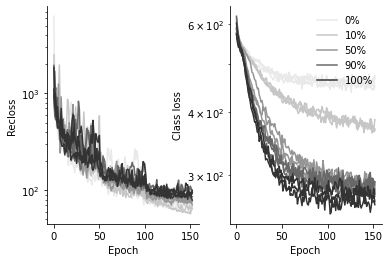

In [77]:
plt.subplot(121)
cs = sns.color_palette('Greys', n_colors=5)
for k, key in enumerate(loss_dict.keys()):
    plt.plot(loss_dict[key][150:,2::4]- loss_dict[key][150:,3::4], c=cs[k])

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Recloss')

plt.subplot(122)
for k, key in enumerate(loss_dict.keys()):
    plt.plot(loss_dict[key][150:,3::4], c=cs[k],  label='%i'%int(float(key)*100) + '%')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Class loss')
handles, legend_labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::3], legend_labels[::3], frameon=False)
sns.despine()

In [78]:
key = '0.0'
ix_1, ix_2, ix_3 = loss_dict[key][:,2::4].argmin(axis=0)
print('MSE: ', loss_dict[key][ix_1,2]-loss_dict[key][ix_1,3], 
      loss_dict[key][ix_2,6] -loss_dict[key][ix_2,7], 
      loss_dict[key][ix_3,10]-  loss_dict[key][ix_3,11])

print('Class: ', loss_dict[key][ix_1,3], loss_dict[key][ix_2,7],loss_dict[key][ix_3,11])

MSE:  66.58554292929296 70.08530618686876 66.1167140151515
Class:  443.103851010101 449.14950284090907 450.30602904040404


From scratch (with pretraining on scaled toy data):

    unsupervised 
                [112.43801294191923 146.75777304292933 125.18864425505058] MSE
                [455.17341382575756 462.9758128156566 476.1843434343434] Class 
                
    supervised
                [190.31143465909093 215.83566130050508 203.27254971590907] MSE
                [264.1150173611111 252.19116950757575 277.10931581439394] Class
            
            
From scratch (with pretraining on scaled rgc data):

    unsupervised 
                [66.58554292929296 70.08530618686876 66.1167140151515] MSE
                [443.103851010101 449.14950284090907 450.30602904040404] Class 
                
    supervised
                [88.16749526515153 92.84732086489902 85.37279040404042] MSE
                [255.32820391414143 266.0277185921717 261.8620580808081] Class
            
            

In [124]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = dict(input_dim =3, embed_dim=32, hidden_dim=32, latent_dim=32, num_layers = 2, kappa=500, dropout=.1)

model = create_model(config, device)
NUM_CLASSES = 14
classifier = PoolingClassifier(config['latent_dim'], NUM_CLASSES, n_walks,config['dropout'], 'max')

KLD: 45.709938049316406


In [125]:
with open('./data/Farrow_data/iterator/%s/train_iterator.pkl'%part, 'rb') as f:
    train_iterator = pickle.load(f)

with open('./data/Farrow_data/iterator/%s/val_iterator.pkl'%part, 'rb') as f:
    val_iterator = pickle.load(f)
    
with open('./data/Farrow_data/iterator/%s/test_iterator.pkl'%part, 'rb') as f:
    test_iterator = pickle.load(f)

SEED = 17
# get data
np.random.seed(SEED)
torch.manual_seed(SEED)
src_data_train = torch.Tensor()
trg_data_train = torch.Tensor() 
seq_len_train = torch.Tensor()
indices_train = torch.Tensor().to(torch.long)
labels_train = torch.Tensor().to(torch.long)

for sd, td, sl, ti, lt in list(train_iterator):
    src_data_train = torch.cat((src_data_train,sd),dim=0)
    trg_data_train = torch.cat((trg_data_train,td),dim=0)
    seq_len_train = torch.cat((seq_len_train,sl),dim=0)
    indices_train = torch.cat((indices_train,ti),dim=0)
    labels_train = torch.cat((labels_train,lt),dim=0)

src_data_val, trg_data_val, seq_len_val, indices_val, labels_val = list(val_iterator)[0]
src_data_test, trg_data_test, seq_len_test, indices_test, labels_test = list(test_iterator)[0]

_ , n_walks, walk_length, f = src_data_test.shape

In [126]:
fractions = [1.,.9,.5,.1, 0.]

model_path = './models/Farrow/finetuned/' + part +'/finetuned_scaled_vae_frac%.1f_best_run%i.pt'
save_path = './data/Farrow_data/latent/%s/scratch/finetuned_'%part
save_r_T(model_path, save_path, fractions)

CPU times: user 144 µs, sys: 9 µs, total: 153 µs
Wall time: 19.6 µs
CPU times: user 379 ms, sys: 1.06 ms, total: 380 ms
Wall time: 28.7 ms
CPU times: user 8.48 s, sys: 119 ms, total: 8.6 s
Wall time: 7.72 s
CPU times: user 143 µs, sys: 9 µs, total: 152 µs
Wall time: 19.1 µs
CPU times: user 352 ms, sys: 313 µs, total: 352 ms
Wall time: 27.1 ms
CPU times: user 8.53 s, sys: 149 ms, total: 8.68 s
Wall time: 7.78 s


No handles with labels found to put in legend.


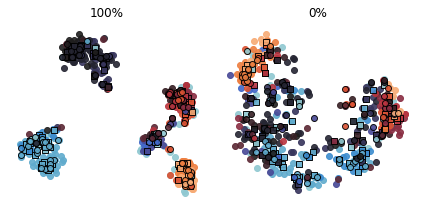

In [135]:
fig, axes = plt.subplots(1,2,figsize=(6,3))
colors = sns.color_palette('icefire', n_colors=15)
for k, (frac, run) in enumerate([(1., 1), (0., 1)]):
    
    with open(save_path + 'neuron_latent_representation_frac_%.1f_run%i_train'%(frac,run), 'rb') as f:
        Z_grouped_train = np.load(f)
        
    with open(save_path + 'neuron_latent_representation_frac_%.1f_run%i_val'%(frac,run), 'rb') as f:
        Z_grouped_val= np.load(f)
    
    with open(save_path + 'neuron_latent_representation_frac_%.1f_run%i_test'%(frac,run), 'rb') as f:
        Z_grouped_test = np.load(f)

    
    Z_grouped_train_pca = pca.fit_transform(np.array(Z_grouped_train))
    %time
    affinities_train = PerplexityBasedNN(
        Z_grouped_train_pca,
        perplexity=30,
        metric="cosine",
        n_jobs=2,
        random_state=17,
    )

    %time init_train = initialization.pca(Z_grouped_train_pca, random_state=17)

    embedding_train = TSNEEmbedding(
        init_train,
        affinities_train,
        negative_gradient_method="fft",
        n_jobs=2
    )

    %time embedding_train = embedding_train.optimize(n_iter=500, momentum=0.8)
    
    embedding_val = embedding_train.prepare_partial(
        pca.transform(np.array(Z_grouped_val)),
        initialization="median",
        k=5,
        perplexity=5,
    )
    
    embedding_test = embedding_train.prepare_partial(
        pca.transform(np.array(Z_grouped_test)),
        initialization="median",
        k=5,
        perplexity=5,
    )

    for kl, l in enumerate(np.unique(labels_train)):
        
        
        label_index_train = labels_train == l
        axes[k].scatter(embedding_train[label_index_train, 0], 
                        embedding_train[label_index_train, 1], 
                    alpha=.9, c=[colors[kl]])
        
         
        label_index_val = labels_val== l
        axes[k].scatter(embedding_val[label_index_val, 0], 
                        embedding_val[label_index_val, 1], 
                    alpha=.9, c=[colors[kl]], edgecolors='k',
                        marker = 's', zorder=900)
        
        label_index_test = labels_test == l
        axes[k].scatter(embedding_test[label_index_test, 0], 
                        embedding_test[label_index_test, 1], 
                    alpha=.9, c=[colors[kl]], edgecolor='k', zorder=1000)
    axes[k].axis('off')
    axes[k].set_title(str(int(frac*100))+'%')

sns.despine()
axes[0].legend(frameon=False, bbox_to_anchor=(.1,.3))
plt.tight_layout()
# plt.savefig('./pics/ICML/camera-ready/Suppl/RGC_rT_scratch.svg', format='svg')

## on max pooled version 

In [57]:
# save the max pooled over original walk data

max_pool = torch.nn.MaxPool3d(kernel_size=(n_walks,1,1))

with open('./data/Farrow_data/max-pooled/max_pooled_train_%s.npy'%part, 'wb') as f:
    bs = trg_data_train.shape[0]
    max_pooled_trg_train = max_pool(trg_data_train).squeeze().reshape(bs, -1)
    np.save(f, max_pooled_trg_train)
with open('./data/Farrow_data/max-pooled/train_labels.npy', 'wb') as f:
    np.save(f,labels_train)
    
    
with open('./data/Farrow_data/max-pooled/max_pooled_test_%s.npy'%part, 'wb') as f:
    bs = trg_data_test.shape[0]
    max_pooled_trg = max_pool(trg_data_test).squeeze().reshape(bs, -1)
    np.save(f, max_pooled_trg)
with open('./data/Farrow_data/max-pooled/test_labels.npy', 'wb') as f:
    np.save(f,labels_test)

CPU times: user 22.2 s, sys: 347 ms, total: 22.5 s
Wall time: 21.5 s


Text(0.5, 1.0, 't-SNE on max-pooled original walks')

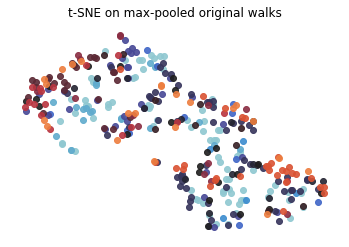

In [58]:
# max pool over the 3d walks directly

max_pool = torch.nn.MaxPool3d(kernel_size=(n_walks,1,1))
bs = trg_data_train.shape[0]
max_pooled_trg = max_pool(trg_data_train).squeeze().reshape(bs, -1)


from openTSNE import TSNE
tsne = TSNE(
    perplexity=20,
    initialization="pca",
    metric="euclidean",
    random_state=17,
    )
%time tsne_fit_max_pooled = tsne.fit(np.array(max_pooled_trg))

colors = sns.color_palette('icefire', n_colors=15)

for l in np.unique(labels_train)[1:]:
    
    plt.scatter(tsne_fit_max_pooled[labels_train == l, 0], 
                tsne_fit_max_pooled[labels_train == l, 1], 
                alpha=.9, c=[colors[l]])

plt.axis('off')
plt.title('t-SNE on max-pooled original walks')